## CV classification task on CIFAR dataset

### Importing modules

In [1]:
import os
logs_base_dir = 'runs'
os.makedirs(logs_base_dir, exist_ok=True)

In [2]:
import copy
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchsummary
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
import random
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
! pip install albumentations==0.5.1

     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 952kB 53.3MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


### Loading and preparing the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/utils.py' .
!cp 'drive/My Drive/Colab Notebooks/CV/Classification/models/resnet50.py' .

In [69]:
import utils
import imp
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

In [70]:
from utils import train_model, evaluate

In [8]:
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

In [9]:
root_path = '/content/cifar10'
mkdir(root_path)

Directory /content/cifar10 is created!


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
NUM_WORKERS = 4
BATCH_SIZE = 128
VAL_RATIO = 0.2

In [71]:
train_loader, val_loader = utils.get_train_val_loader(data_dir=root_path,
                                                      batch_size=BATCH_SIZE,
                                                      val_size=VAL_RATIO,
                                                      num_workers=NUM_WORKERS)

test_loader = utils.get_test_loader(data_dir=root_path,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [82]:
def get_test_results(model, device, test_loader, criterion):
    loss, accuracy = evaluate(model, device, test_loader, criterion)
    print('Loss on the test data: {:.3f}'.format(loss))
    print('Accuracy on test data: {:.3f}'.format(accuracy))

### Testing `ResNet50` implemented from scratch

Let's use from scratch implementation of ResNet50 architecture. The code of it is in resnet50.py file.

In [14]:
import resnet50
imp.reload(resnet50)

<module 'resnet50' from '/content/resnet50.py'>

In [15]:
resnet50_model = resnet50.ResNet50(resnet50.ConvBlock, num_classes=10)

In [16]:
resnet50_model.to(device)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block_layer1): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (res_connection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(in

In [63]:
N_EPOCHS = 10
opt = torch.optim.Adam(resnet50_model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=100)

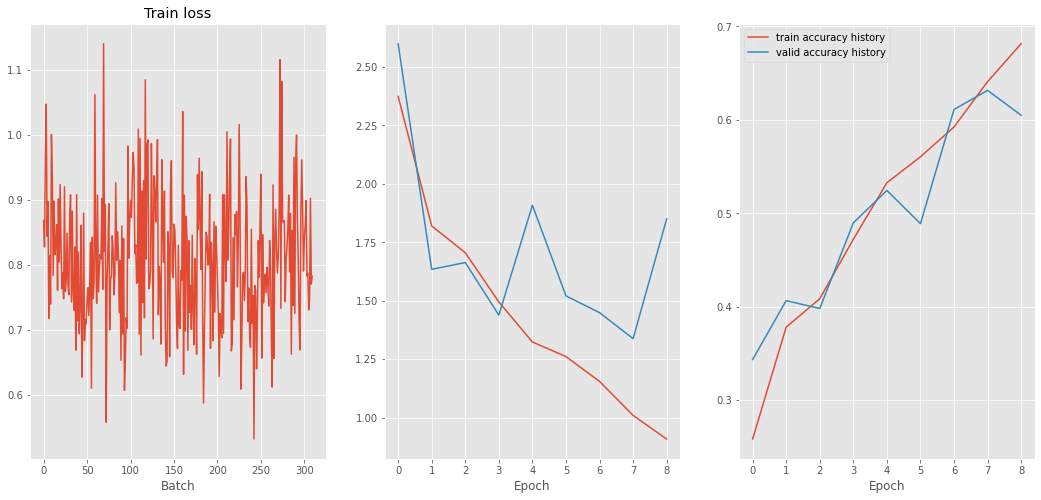

Epoch: 10 | Time: 0m 50s
	Train Loss: 0.809
	 Val. Loss: 0.883


In [18]:
train_model(resnet50_model, 
            device, 
            train_loader, 
            val_loader, 
            opt, 
            criterion, 
            lr_scheduler, 
            N_EPOCHS, 
            clip=1, 
            model_name='resnet50_model.pth')

In [83]:
get_test_results(resnet50_model, device, test_loader, criterion)

Loss on the test data: 0.910
Accuracy on test data: 0.689


### Testing pretrained models

Let's use some prepared [models for classification](https://pytorch.org/docs/stable/torchvision/models.html#classification) from torchvision. We will apply pretrained versions of models to use them as feature extractors and also train these models from scratch to compare their perfomances.

#### Densenet-201

##### Pretrained with freezing all the weights

In [19]:
densenet201_pr = models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


In [20]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in densenet201_pr.parameters():
    param.requires_grad = False

fc_in = densenet201_pr.classifier.in_features
densenet201_pr.classifier = nn.Linear(fc_in, 10)

densenet201_pr.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
N_EPOCHS = 10
opt = torch.optim.Adam(densenet201_pr.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=2, gamma=0.1)

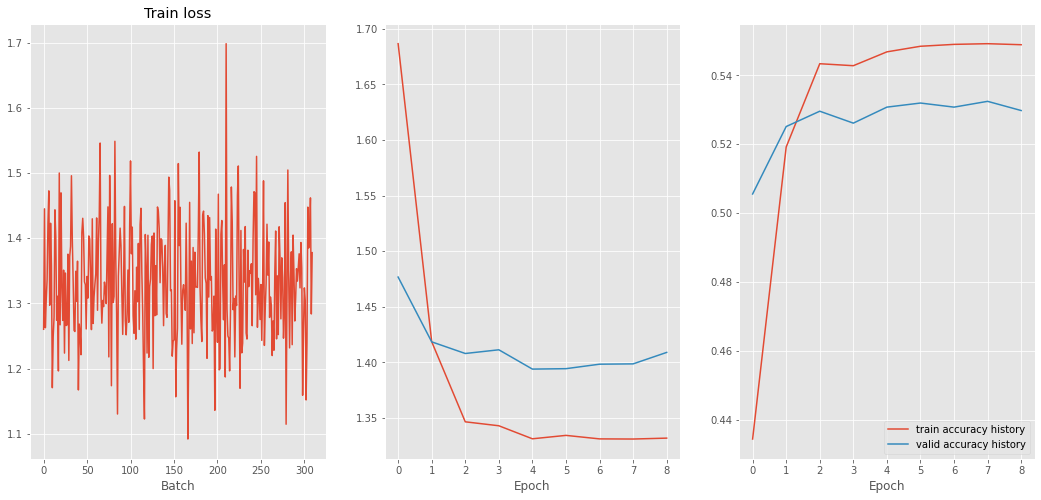

Epoch: 10 | Time: 0m 37s
	Train Loss: 1.333
	 Val. Loss: 1.403


In [22]:
train_model(densenet201_pr,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='densenet_201_pr.pth')

In [81]:
get_test_results(densenet201_pr, device, test_loader, criterion)

Loss on the test data = 1.409
Accuracy on test data = 0.526


##### Training from scratch

In [23]:
densenet201 = models.densenet201(pretrained=False)

In [24]:
fc_in = densenet201.classifier.in_features
densenet201.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

densenet201.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [25]:
N_EPOCHS = 10
opt = torch.optim.Adam(densenet201.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

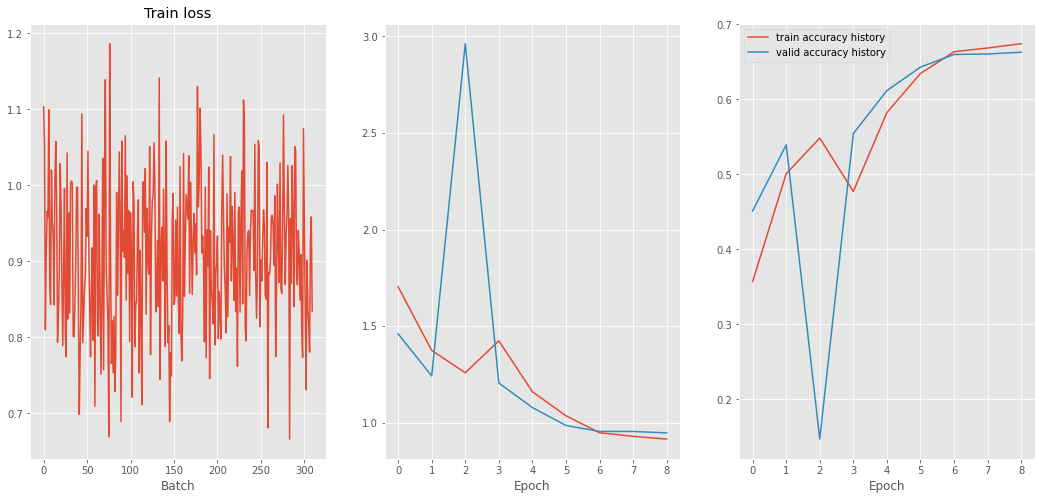

Epoch: 10 | Time: 1m 23s
	Train Loss: 0.907
	 Val. Loss: 0.944


In [26]:
train_model(densenet201,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='densenet201.pth')

In [84]:
get_test_results(densenet201, device, test_loader, criterion)

Loss on the test data: 0.959
Accuracy on test data: 0.660


#### MobileNet V2

##### Pretrained with freezing all the weights

Let's freeze all the network's weights except the final layers.

In [27]:
mobilenet_pr_fr = models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [28]:
# freezing all the network's weights except the final dense layer to use the 
# net as a fixed feature extractor

for param in mobilenet_pr_fr.parameters():
    param.requires_grad = False

fc_in = mobilenet_pr_fr.classifier[1].in_features
mobilenet_pr_fr.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_pr_fr.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [29]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_pr_fr.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

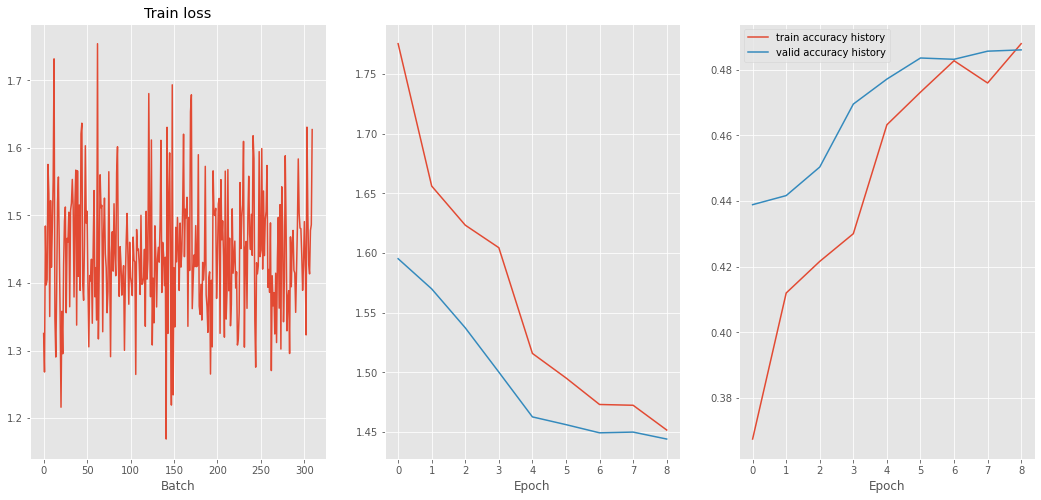

Epoch: 10 | Time: 0m 25s
	Train Loss: 1.446
	 Val. Loss: 1.452


In [30]:
train_model(mobilenet_pr_fr,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet_pr_fr.pth')

In [85]:
get_test_results(mobilenet_pr_fr, device, test_loader, criterion)

Loss on the test data: 1.448
Accuracy on test data: 0.495


##### Pretrained with backpropagation through all the layers

Now we won't freeze the weights and allow backpropagation through all layers. 

In [105]:
mobilenet_pr = models.mobilenet_v2(pretrained=True)

In [106]:
fc_in = mobilenet_pr.classifier[1].in_features
mobilenet_pr.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_pr.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [107]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_pr.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

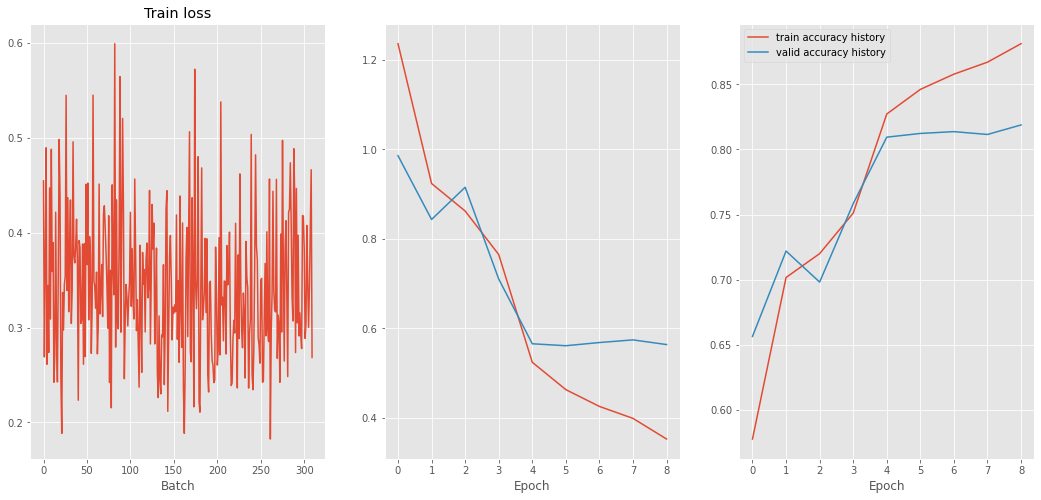

Epoch: 10 | Time: 0m 33s
	Train Loss: 0.343
	 Val. Loss: 0.569


In [108]:
train_times_no_amp, val_times_no_amp = train_model(mobilenet_pr,
                                                   device,
                                                   train_loader,
                                                   val_loader,
                                                   opt,
                                                   criterion,
                                                   lr_scheduler,
                                                   N_EPOCHS,
                                                   clip=1,
                                                   model_name='mobilenet_pr.pth',
                                                   return_time=True)

In [109]:
get_test_results(mobilenet_pr, device, test_loader, criterion)

Loss on the test data: 0.601
Accuracy on test data: 0.812


##### Training from scratch

In [35]:
mobilenet = models.mobilenet_v2(pretrained=False)

In [36]:
fc_in = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [37]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=4, gamma=0.1)

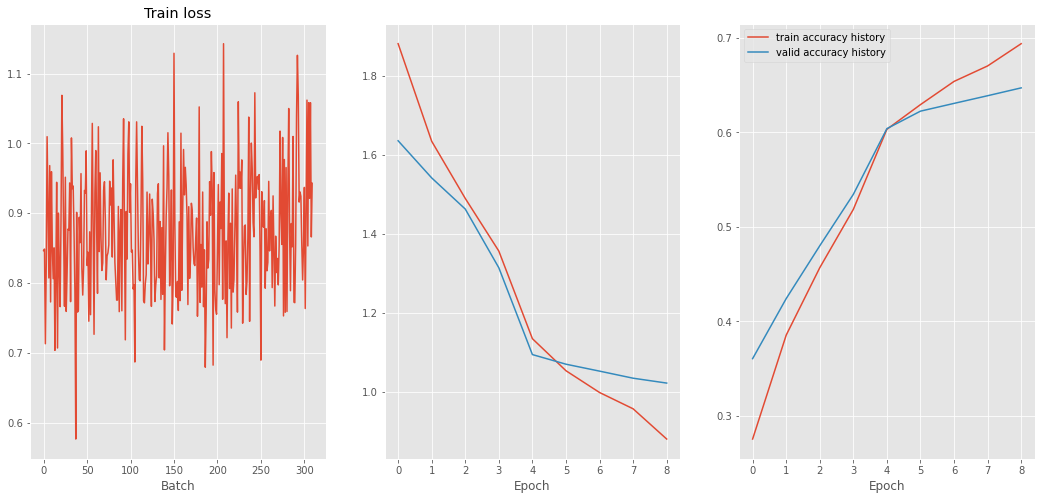

Epoch: 10 | Time: 0m 34s
	Train Loss: 0.872
	 Val. Loss: 1.018


In [38]:
train_model(mobilenet,
            device,
            train_loader,
            val_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet.pth')

In [87]:
get_test_results(mobilenet, device, test_loader, criterion)

Loss on the test data: 1.018
Accuracy on test data: 0.653


#### Conclusions

We see that using pretrained models as fixed feature extractors without allowing backpropagation through its layers for this task and data shows worse performance than training from scratch or using pretrained models with backprop. In case of mobilenet pretraining with backprop significantly outperformed training from scratch, however I suppose that it would achive better results with applying more sophisticated techniques like setting different learning rate for different layers of network, etc.

### Adding augmentations from `albumentations`

Let's use some augmentations from albumentations library to test the performance of the best model above(pretrained mobilenet with backpropagation through all the layers).

In [51]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [52]:
train_transform = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        # A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        # A.CLAHE(p=1.0, clip_limit=2.0),
        # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, 
        #                    rotate_limit=15),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

train_aug_loader, val_aug_loader = utils.get_train_val_loader(data_dir=root_path,
                                                              batch_size=BATCH_SIZE,
                                                              train_transform=train_transform,
                                                              val_transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [53]:
mobilenet_aug = models.mobilenet_v2(pretrained=True)

In [54]:
fc_in = mobilenet_aug.classifier[1].in_features
mobilenet_aug.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_aug.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [55]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_aug.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

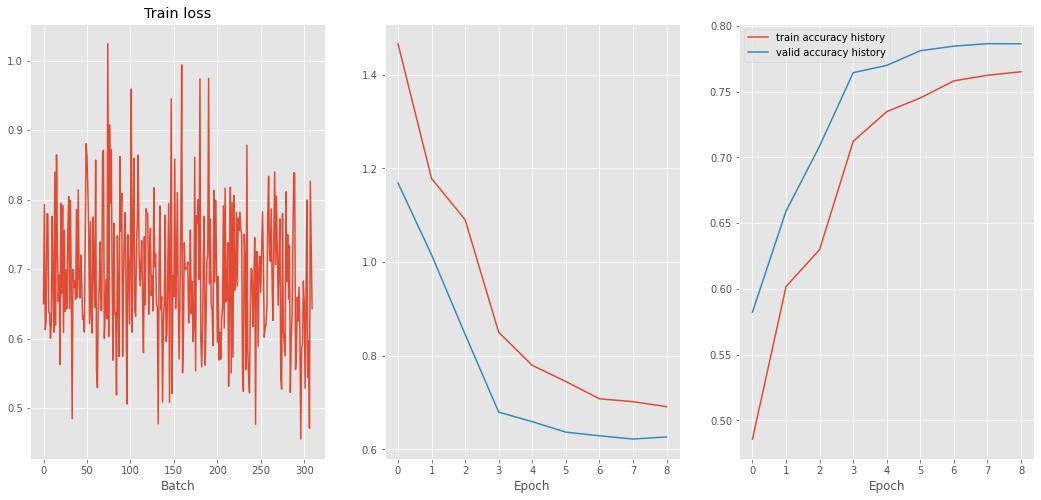

Epoch: 10 | Time: 0m 36s
	Train Loss: 0.691
	 Val. Loss: 0.627


In [56]:
train_model(mobilenet_aug,
            device,
            train_aug_loader,
            val_aug_loader,
            opt,
            criterion,
            lr_scheduler,
            N_EPOCHS,
            clip=1,
            model_name='mobilenet_aug.pth')

In [88]:
get_test_results(mobilenet_aug, device, test_loader, criterion)

Loss on the test data: 0.645
Accuracy on test data: 0.779


I found that applying a big number of complicated augmentations, which significantly change the image, could make the performance of the model worse. Maybe the model has to be trained for much more epochs in this case to become to robust.

### Automatic mixed precision

In [113]:
mobilenet_amp = models.mobilenet_v2(pretrained=True)

In [114]:
fc_in = mobilenet_amp.classifier[1].in_features
mobilenet_amp.classifier = nn.Sequential(
    nn.Linear(fc_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10),
)

mobilenet_amp.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [115]:
N_EPOCHS = 10
opt = torch.optim.Adam(mobilenet_amp.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=3, gamma=0.1)

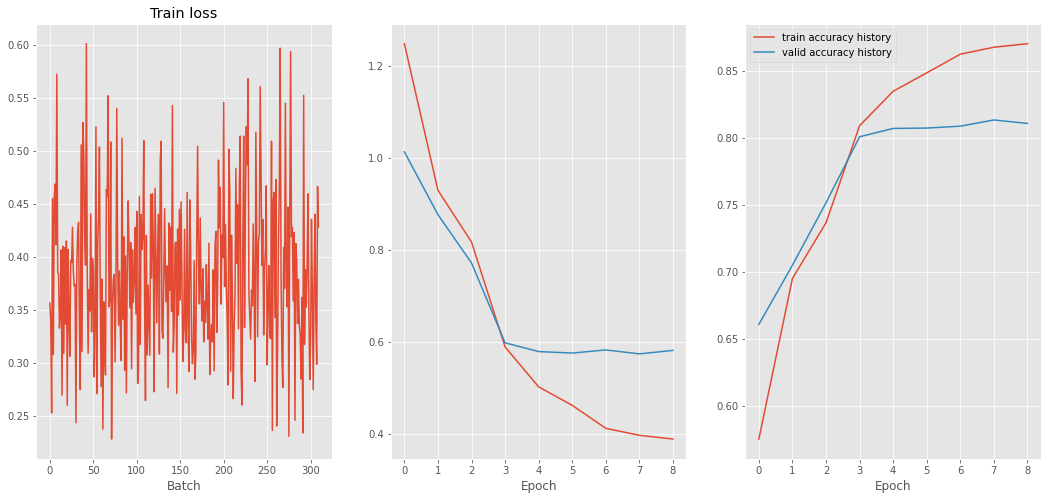

Epoch: 10 | Time: 0m 38s
	Train Loss: 0.383
	 Val. Loss: 0.584


In [116]:
train_times_amp, val_times_amp = train_model(mobilenet_amp,
                                             device,
                                             train_loader,
                                             val_loader,
                                             opt,
                                             criterion,
                                             lr_scheduler,
                                             N_EPOCHS,
                                             clip=1,
                                             enable_mixed_precision=True,
                                             model_name='mobilenet_amp.pth',
                                             return_time=True)

Let's plot the elapsed time for mobilenet model in two cases: when AMP was enabled and disabled, and compare them.

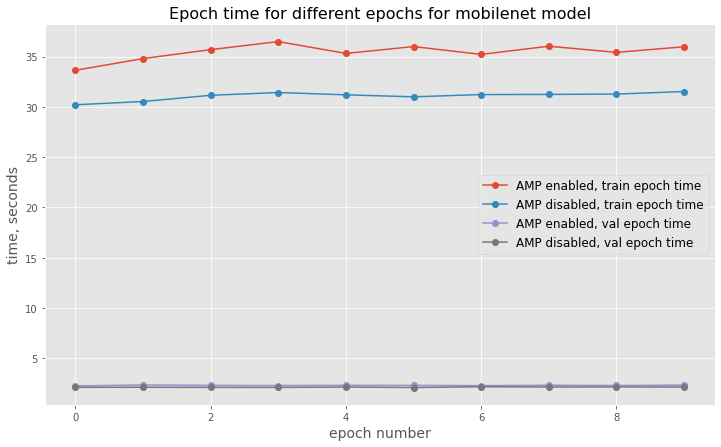

In [118]:
plt.figure(figsize=(12, 7))
plt.title('Epoch time for different epochs for mobilenet model', fontsize=16)
plt.plot(train_times_amp, marker='o', label='AMP enabled, train epoch time')
plt.plot(train_times_no_amp, marker='o', label='AMP disabled, train epoch time')
plt.plot(val_times_amp, marker='o', label='AMP enabled, val epoch time')
plt.plot(val_times_no_amp, marker='o', label='AMP disabled, val epoch time')
plt.legend(fontsize=12, loc='best')
plt.xlabel("epoch number", fontsize=14)
plt.ylabel('time, seconds', fontsize=14)
plt.show()

In [61]:
! cp mobilenet.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_pr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_pr_fr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_aug.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp mobilenet_amp.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp densenet201.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp densenet_201_pr.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'
! cp resnet50_model.pth 'drive/My Drive/Colab Notebooks/CV/Classification/'

In [89]:
imp.reload(utils)
from utils import train_model

In [ ]:
model = resnet50.ResNet50(resnet50.ConvBlock, num_classes=10)
model_save_name = 'resnet50_model.pth'
path = F"/content/drive/My Drive/Colab Notebooks/CV/Classification/{model_save_name}"
model.load_state_dict(torch.load(path))

In [ ]:
# writer = SummaryWriter() 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs